# <center> Проект_4: Задача классификации

Импорт необходимых библиотек:

In [733]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
import optuna
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn import model_selection

data = 'C:/Users/admin/Desktop/FDSupportBK/my_projects_DST120/edu_projects/project_4_classification/bank_fin.csv'

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

**1.1** Посмотрим на наши данные

In [622]:
bank_data = pd.read_csv(data, sep = ';')
print('Data shape: {}'.format(bank_data.shape))
#bank_data.info()
display(bank_data)

Data shape: (11162, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,"1,00 $",yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,"733,00 $",no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,"29,00 $",no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0 $,no,yes,cellular,8,may,9,2,172,5,failure,no


In [623]:
# Исследуем данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
missing_values = bank_data.isnull().sum()
print("Количество пропущенных значений в каждом признаке:")
print(missing_values)

Количество пропущенных значений в каждом признаке:
age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64


Признак balance содержит 25 пропущенных значений

**1.2**

In [624]:
# Проверим, есть ли в признаке job пропущенные значения. Возможно, они обозначены каким-то специальным словом.
# Для начала выведем все возможные варианты признака job
print(bank_data['job'].unique())

['admin.' 'technician' 'services' 'management' 'retired' 'blue-collar'
 'unemployed' 'entrepreneur' 'housemaid' 'unknown' 'self-employed'
 'student']


Вреди всех возможных вариантов есть unknown. Оно как раз и подходит под пропущенные значения.

In [625]:
# Посчитаем кол-во таких пропущенных значений
print("Количество пропущенных значений признака job:", bank_data['job'].value_counts()['unknown'])

Количество пропущенных значений признака job: 70


**1.3**

In [626]:
# Преобразуем признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
# Для преобразования признака "balance" в вещественное число (float), 
# нужно убрать возможные разделители и заменить их на точку (если они представлены в виде запятой). Потом уже преобразовать в float.
# Для начала посмотрим на наш признак balance
print(bank_data['balance'].head(10))

0     2 343,00 $ 
1        45,00 $ 
2     1 270,00 $ 
3     2 476,00 $ 
4       184,00 $ 
5           0  $ 
6       830,00 $ 
7       545,00 $ 
8         1,00 $ 
9             NaN
Name: balance, dtype: object


Видим, что признак содержит: пробелы, ненужные нули с запятой, знак $

In [627]:
# Воспользуемся регулярным выражением для замены всех символов
bank_data['balance'] = bank_data['balance'].str.replace(',', '.').str.replace(' ', '').str.replace('$', '').astype(float)

# Посмотрим на результат первых 10 строк
print(bank_data['balance'].head(10))

0    2343.0
1      45.0
2    1270.0
3    2476.0
4     184.0
5       0.0
6     830.0
7     545.0
8       1.0
9       NaN
Name: balance, dtype: float64


In [628]:
# Найдем среднее значение по преобразованному признаку (ответ округлим до трех знаков после точки-разделителя)
print(round(bank_data['balance'].mean(), 3))

1529.129


**1.4**

In [629]:
# Обработаем пропуски в признаке balance , заменив их на медианные значения по данному признаку
median_balance = bank_data['balance'].median()
bank_data['balance'].fillna(median_balance, inplace=True)
print(bank_data['balance'].head(10))

0    2343.0
1      45.0
2    1270.0
3    2476.0
4     184.0
5       0.0
6     830.0
7     545.0
8       1.0
9     550.0
Name: balance, dtype: float64


Видим, что значение NaN 9й строчки заменилось на медианное значение.

In [630]:
# Найдем теперь среднее значение по преобразованному признаку (ответ округлим до трех знаков после точки-разделителя)
print(round(bank_data['balance'].mean(), 3))

1526.936


**1.5**

In [631]:
# Обработаем пропуски в категориальных признаках: job и education, заменив их на модальные значения
mode_job = bank_data['job'].mode().iloc[0]
bank_data['job'] = bank_data['job'].apply(lambda x: mode_job if x == 'unknown' else x)

mode_education = bank_data['education'].mode().iloc[0]
bank_data['education'] = bank_data['education'].apply(lambda x: mode_education if x == 'unknown' else x)

In [632]:
# После замены пропусков рассчитаем средний баланс для клиентов с самой популярной работой 
# и самым популярным уровнем образования (т. е. для тех, у кого одновременно самая популярная работа и самое популярное образование). 
# (ответ округлим до трёх знаков после точки-разделителя)

# Для начала посмотрим, какая у нас самая популярная работа и самый популярный уровень образования
popular_job = mode_job
popular_education = mode_education
print("Самая популярная работа:", popular_job)
print("Самый популярный уровень образования:", popular_education)

Самая популярная работа: management
Самый популярный уровень образования: secondary


In [633]:
# Теперь отфильтруем данные для таких клиентов
filtered_popular_data = bank_data[(bank_data['job'] == popular_job) & (bank_data['education'] == popular_education)]
# Посмотрим на средний баланс
print("Средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования:", round(filtered_popular_data['balance'].mean(), 3))

Средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования: 1598.883


**1.6**

In [634]:
# Удалим все выбросы для признака balance. Используем для этого IQR(интерквартильный размах).
# Для начала вычислим первый и третий квартили (Q1, Q3)
Q1 = bank_data['balance'].quantile(0.25)
Q3 = bank_data['balance'].quantile(0.75)
# Теперь вычислим IQR
IQR = Q3 - Q1

# Теперь нужно определить нижнюю и верхнюю границы выбросов по известной формуле
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Фильтруем наш датасет оставляя только те строки, 
# где значения признака "balance" находятся в пределах нижней и верхней границ выбросов
bank_data = bank_data[(bank_data['balance'] >= lower_bound) & (bank_data['balance'] <= upper_bound)]

In [635]:
# Выведем верхную и нижнюю границы поиска выбросов. (ответ округлим до целых чисел)
print(round(lower_bound))
print(round(upper_bound))

-2241
4063


In [636]:
# Посмотрим сколько осталось строк после удаления всех выбросов
bank_data.shape

(10105, 17)

## Часть 2:  Разведывательный анализ данных (EDA)

**2.1**

Распределение ответов клиентов:
no     5424
yes    4681
Name: deposit, dtype: int64


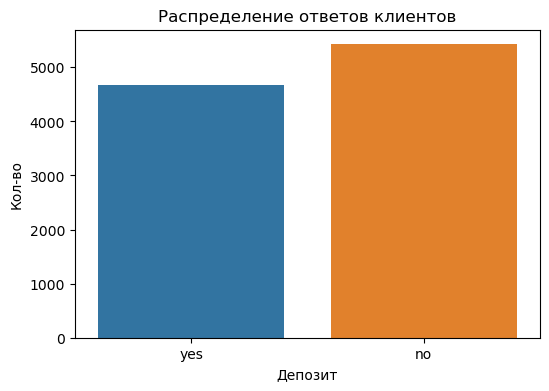

In [637]:
# Изучим соотношение классов в наших данных на предмет несбалансированности и проиллюстрируем результат
# Для этого нам нужно рассмотреть нашу целевую переменную deposit 
# и визуализировать на диаграмме ответы клиентов: yes - согласен на депозит, no - не согласен на депозит

# Для начала подсчитаем количество значений в целевой переменной
class_counts = bank_data['deposit'].value_counts()

# Выведем точные значения
print("Распределение ответов клиентов:")
print(class_counts)

# Выведем визуализацию соотношения классов
plt.figure(figsize=(6, 4))
sns.countplot(x='deposit', data=bank_data)
plt.xlabel('Депозит')
plt.ylabel('Кол-во')
plt.title('Распределение ответов клиентов')
plt.show()

**2.2 и 2.3**

In [638]:
# Рассчитаем описательные статистики для количественных переменных, далее проинтерпретируем результат
# В этом нам поможет метод describe()
bank_data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


Проинтерпретируем результаты:

* **age**: Возраст клиентов имеет среднее значение - 40-41. Минимальный возраст -18 и максимальный возраст - 95.
* **balance**: Средний баланс клиентов - 84300. Минимальный баланс - 0 и максимальный баланс - 401200.
* **duration**: Средняя продолжительность контактов с клиентами. Минимальное и максимальное значения указывают на диапазон длительности контактов.
* **campaign**: Среднее количество контактов с клиентом в рамках текущей кампании. Минимальное и максимальное значения показывают разброс количества контактов.
* **pdays**: Количество дней с момента последней маркетинговой кампании до контакта в текущей кампании. Среднее значение и стандартное отклонение могут указывать на паттерны контактов клиентов после прошлых кампаний.
* **previous**: Количество контактов до текущей кампании. Среднее значение и стандартное отклонение могут указывать на активность клиентов до текущей кампании. То есть больше половины участников не контактировали с банком ранее.

**2.4 и 2.5**

In [639]:
# Рассчитаем описательные статистики для категориальных переменных, далее проинтерпретируем результат
# В этом нам поможем метод value_counts()
# Рассчитаем описательные статистики для наших категориальных переменных
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

for feature in categorical_features:
    print(f"\nКатегориальный признак: {feature}")
    print(bank_data[feature].value_counts())


Категориальный признак: job
management       2315
blue-collar      1807
technician       1638
admin.           1246
services          868
retired           663
self-employed     358
unemployed        332
student           326
entrepreneur      300
housemaid         252
Name: job, dtype: int64

Категориальный признак: marital
married     5715
single      3213
divorced    1177
Name: marital, dtype: int64

Категориальный признак: education
secondary    5517
tertiary     3239
primary      1349
Name: education, dtype: int64

Категориальный признак: default
no     9939
yes     166
Name: default, dtype: int64

Категориальный признак: housing
no     5243
yes    4862
Name: housing, dtype: int64

Категориальный признак: loan
no     8712
yes    1393
Name: loan, dtype: int64

Категориальный признак: contact
cellular     7283
unknown      2161
telephone     661
Name: contact, dtype: int64

Категориальный признак: month
may    2617
jul    1418
aug    1385
jun    1104
apr     830
nov     780
feb    

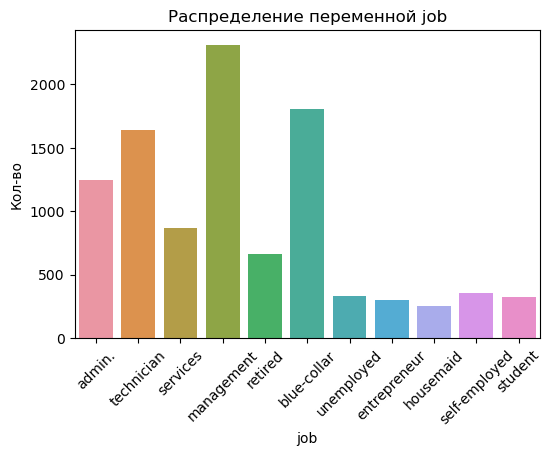

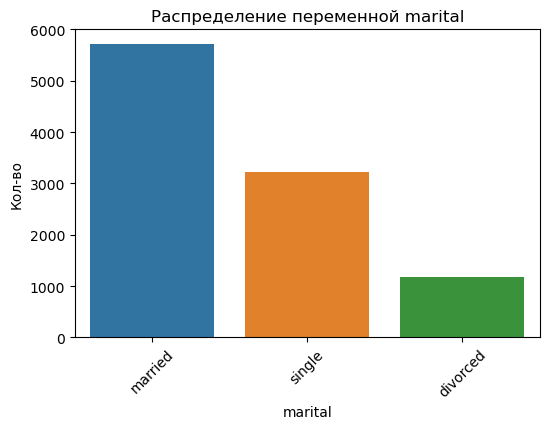

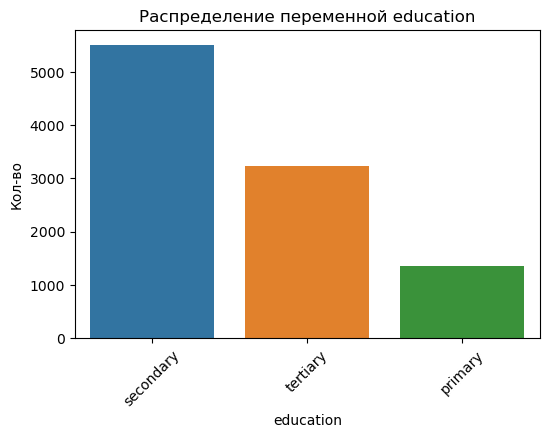

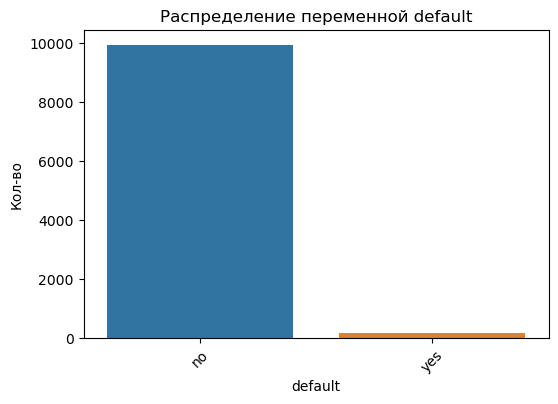

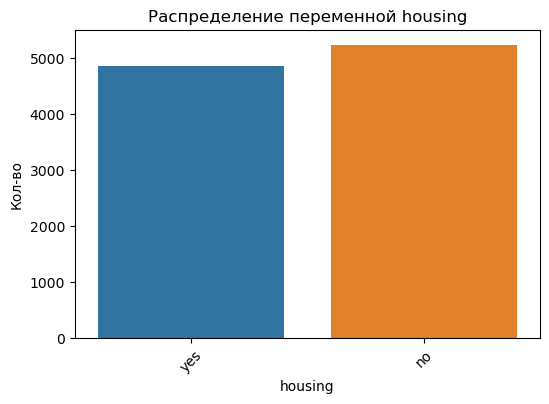

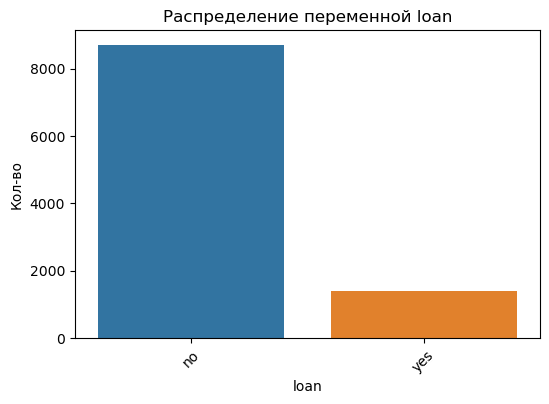

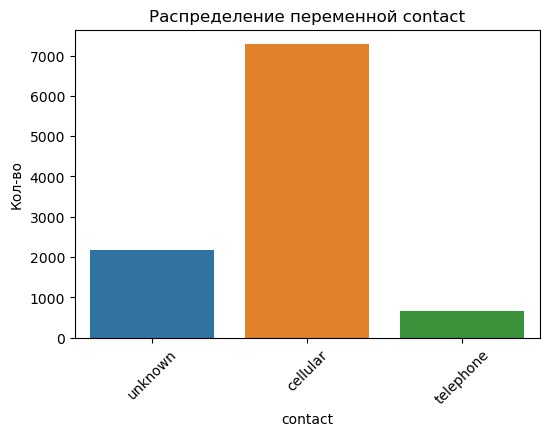

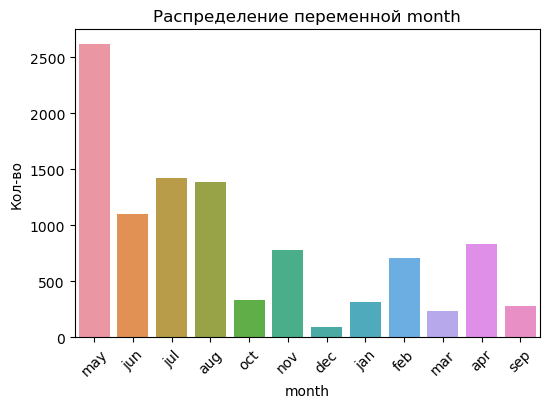

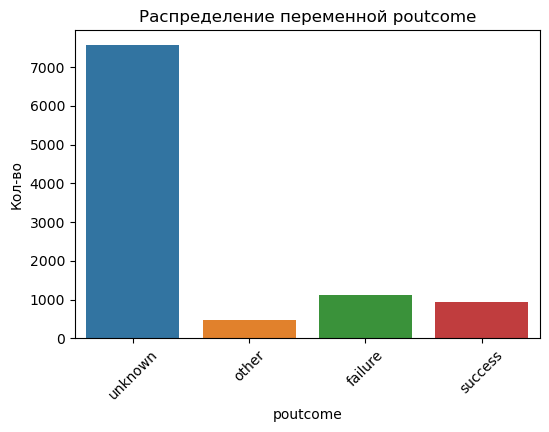

In [640]:
# Визуализируем наши результаты
# Для визуализации описательных статистик категориальных переменных, мы можем использовать столбчатые диаграммы
for feature in categorical_features:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=feature, data=bank_data)
    plt.title(f"Распределение переменной {feature}")
    plt.xlabel(feature)
    plt.ylabel("Кол-во")
    plt.xticks(rotation=45)
    plt.show()
    

Видим, что наиболее распространённая работа - менеджмент, семейное положение - женат/замужем 
Типичный участник не имеет задолженностей/кредитов и просрочек оплаты

**2.6**

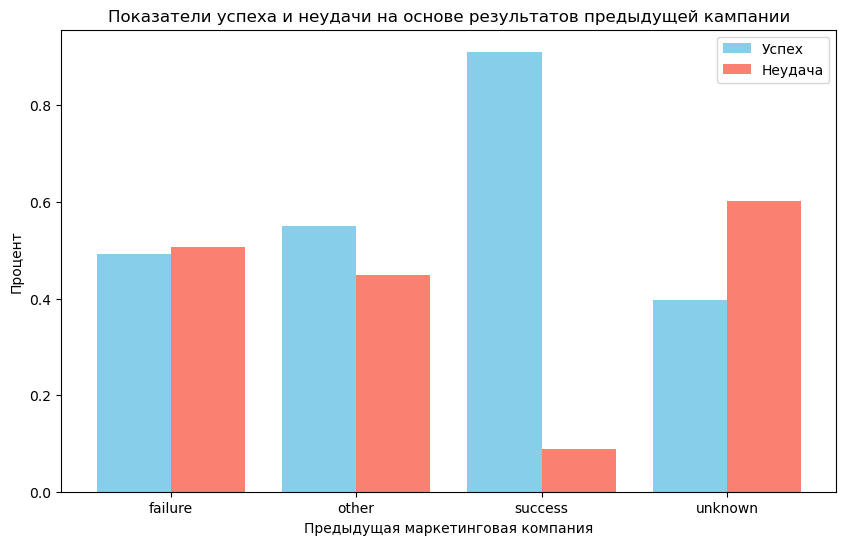

In [641]:
# Узнаем, для какого статуса предыдущей маркетинговой кампании успех в текущей кампании превалирует над количеством неудач.

# Признак poutcome отвечает за результат предыдущей маркетинговой кампанииимеет и имеет следующие уникальные значения:
# unknown - результат предыдущей кампании неизвестен
# failure - предыдущая кампания была неудачной
# other - предыдущая кампания имела другой результат
# success - предыдущая кампания была успешной

# Чтобы ответить на наш вопрос мы можем сгруппировать данные по значению poutcome и проанализировать 
# процент успешных и неудачных результатов в текущей кампании.

# Сгруппируем данные по признаку poutcome и рассчитаем долю успешных и неудачных результатов в текущей кампании
poutcome_grouped = bank_data.groupby('poutcome')['deposit'].value_counts(normalize=True).unstack()


# Посмотрим на результат. Используем bar с отдельными столбцами для категорий "Успех", "Неудача"
plt.figure(figsize=(10, 6))
bar_width = 0.4
bar_positions = np.arange(len(poutcome_grouped.index))

plt.bar(bar_positions, poutcome_grouped['yes'], width=bar_width, color='skyblue', label='Успех')
plt.bar(bar_positions + bar_width, poutcome_grouped['no'], width=bar_width, color='salmon', label='Неудача')
plt.title('Показатели успеха и неудачи на основе результатов предыдущей кампании')
plt.xlabel('Предыдущая маркетинговая компания')
plt.ylabel('Процент')
plt.xticks(bar_positions + bar_width / 2, poutcome_grouped.index)
plt.legend()
plt.show()

Доля успешных (синий столбец) и неудачных (красный столбец) результатов текущей кампании для каждого значения poutcome.
Доля успеха превышает долю неудач у значений - success и other. Это может указывать на определенный статус предыдущей кампании, при котором успех в текущей кампании превалирует над количеством неудач.

**2.7**

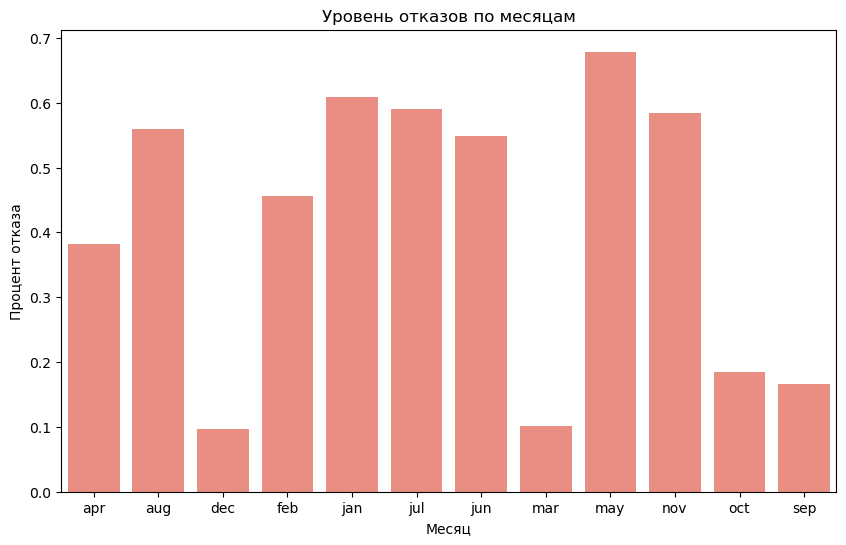

In [642]:
# Узнаем, в каком месяце чаще всего отказывались от предложения открыть депозит
# Для жтого мы можем проанализировать признак month, который содержит информацию о месяце, 
# в котором был последний контакт с клиентом в рамках текущей маркетинговой кампании, и сгруппировать данные по этому признаку.

# Сгруппмруем данные по признаку month и рассчитаем долю отказов в текущей кампании
month_grouped = bank_data.groupby('month')['deposit'].value_counts(normalize=True).unstack()

# Посмотрим на результат
plt.figure(figsize=(10, 6))
sns.barplot(x=month_grouped.index, y=month_grouped['no'], color='salmon')
plt.title('Уровень отказов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Процент отказа')
plt.show()

На этой диаграмме мы видим долю отказов в текущей кампании для каждого месяца. Май нам показывает наибольшую долю отказов от предложения открыть депозит.

**2.8**

In [643]:
# Теперь создадим возрастные группы и определим, 
# в каких группах более склонны открывать депозит, чем отказываться от предложения.
# В данном случае лучше будет использовать sns.barplot, так как он позволяет отображать процентные значения вместо абсолютных.
# А параметр normalize=True метода value_counts() используем для нормализации значений, 
# чтобы получить процентные значения относительно каждой возрастной группы.

# Посмотрим для начала на возраст клиентов в порядке возрастания 
print(bank_data['age'].sort_values().unique())

[18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65
 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89
 90 92 93 95]


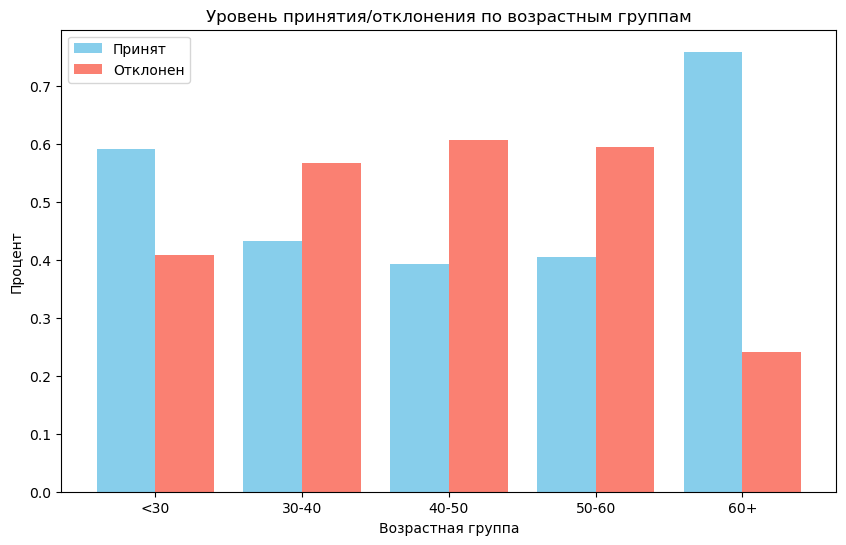

In [644]:
# Теперь создадим возрастные группы
bins = [18, 30, 40, 50, 60, 95]
labels = ['<30', '30-40', '40-50', '50-60', '60+']

# Теперь создадим признак возрастных групп age_group
bank_data['age_group'] = pd.cut(bank_data['age'], bins=bins, labels=labels, right=False)

# Теперь сгруппируем данные по возрастным группам и рассчитаем долю отказов и согласий в каждой группе
age_grouped = bank_data.groupby('age_group')['deposit'].value_counts(normalize=True).unstack()

# Посмотрим на результат. Используем bar с отдельными столбцами для категорий "Принят", "Отклонен"
plt.figure(figsize=(10, 6))
bar_width = 0.4
bar_positions = np.arange(len(age_grouped.index))

plt.bar(bar_positions, age_grouped['yes'], width=bar_width, color='skyblue', label='Принят')
plt.bar(bar_positions + bar_width, age_grouped['no'], width=bar_width, color='salmon', label='Отклонен')

plt.title('Уровень принятия/отклонения по возрастным группам')
plt.xlabel('Возрастная группа')
plt.ylabel('Процент')
plt.xticks(bar_positions + bar_width / 2, age_grouped.index)
plt.legend()
plt.show()

Видим, что в возрастных группах - <30 и 60+ клиенты более склонны открывать депозит, чем отказываться от предложения. Причем в возрастной группе 60+ их больше всего.

**2.9 и 2.10**

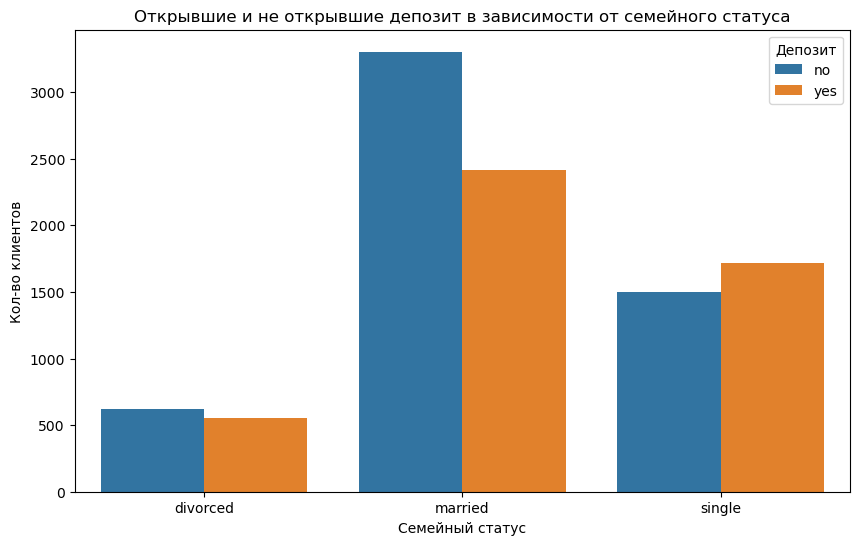

In [645]:
# Сгруппируем данные по семейному статусу и целевой переменной deposit
merital_deposit = bank_data.groupby(['marital', 'deposit']).size().reset_index(name='count')

# Визуализируем количество клиентов для открывших и не открывших депозит в зависимости от семейного статуса
plt.figure(figsize=(10, 6))
sns.barplot(x='marital', y='count', hue='deposit', data=merital_deposit)
plt.title('Открывшие и не открывшие депозит в зависимости от семейного статуса')
plt.xlabel('Семейный статус')
plt.ylabel('Кол-во клиентов')
plt.legend(title='Депозит')
plt.show()

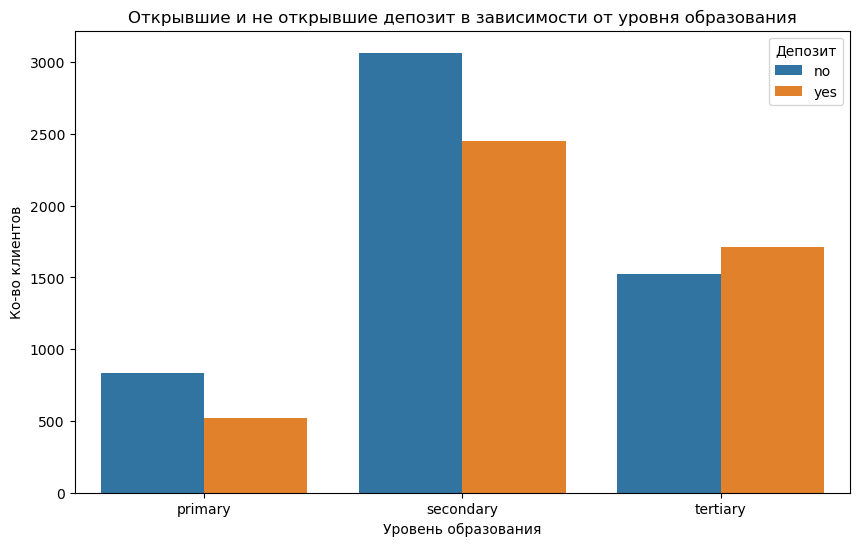

In [646]:
# Сгруппируем данные по уровню образования и целевой переменной deposit
education_deposit = bank_data.groupby(['education', 'deposit']).size().reset_index(name='count')

# Визуализируем количество клиентов для открывших и не открывших депозит в зависимости от уровня образования
plt.figure(figsize=(10, 6))
sns.barplot(x='education', y='count', hue='deposit', data=education_deposit)
plt.title('Открывшие и не открывшие депозит в зависимости от уровня образования')
plt.xlabel('Уровень образования')
plt.ylabel('Ко-во клиентов')
plt.legend(title='Депозит')
plt.show()

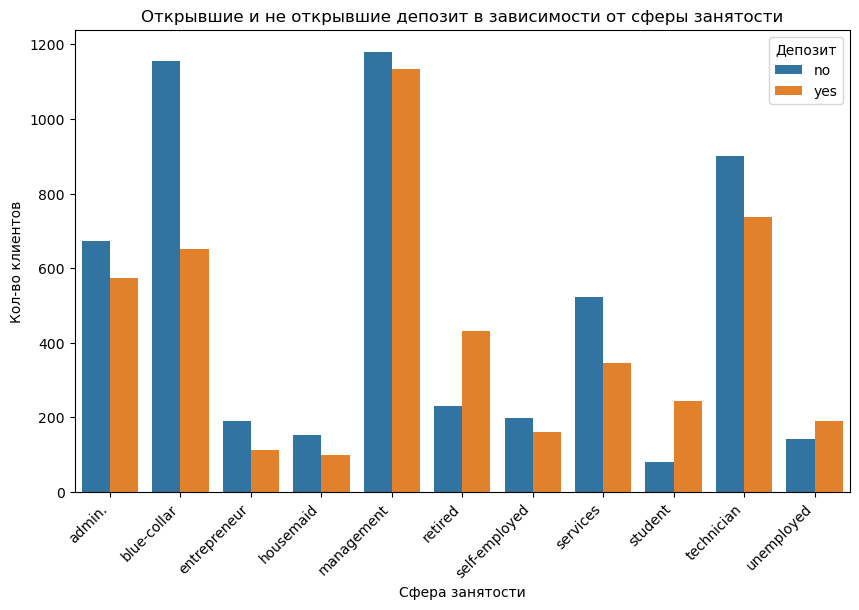

In [647]:
# Сгруппируем данные по уровню образования и целевой переменной deposit
job_deposit = bank_data.groupby(['job', 'deposit']).size().reset_index(name='count')

# Построим визуализации для открывших и не открывших депозит в зависимости от вида профессиональной занятости
plt.figure(figsize=(10, 6))
sns.barplot(x='job', y='count', hue='deposit', data=job_deposit)
plt.title('Открывшие и не открывшие депозит в зависимости от сферы занятости')
plt.xlabel('Сфера занятости')
plt.ylabel('Кол-во клиентов')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Депозит')
plt.show()

**2.11**

In [648]:
# Создадим сводную таблицу, чтобы определить людей с каким образованием и семейным статусом больше всего
# (если рассматривать тех, кто открыл депозит)
pivot_table_deposit = bank_data[bank_data['deposit'] == 'yes'].pivot_table(index=['education', 'marital'], aggfunc='size').reset_index(name='count')
#display(pivot_table_deposit)
# Отсортируем таблицу в порядке убывания кол-ва открытых депозитов
pivot_table_deposit = pivot_table_deposit.sort_values(by='count', ascending=False)
display(pivot_table_deposit)

,education,marital,count
4,secondary,married,1289
5,secondary,single,879
7,tertiary,married,784
8,tertiary,single,755
1,primary,married,339
3,secondary,divorced,283
6,tertiary,divorced,174
0,primary,divorced,96
2,primary,single,82


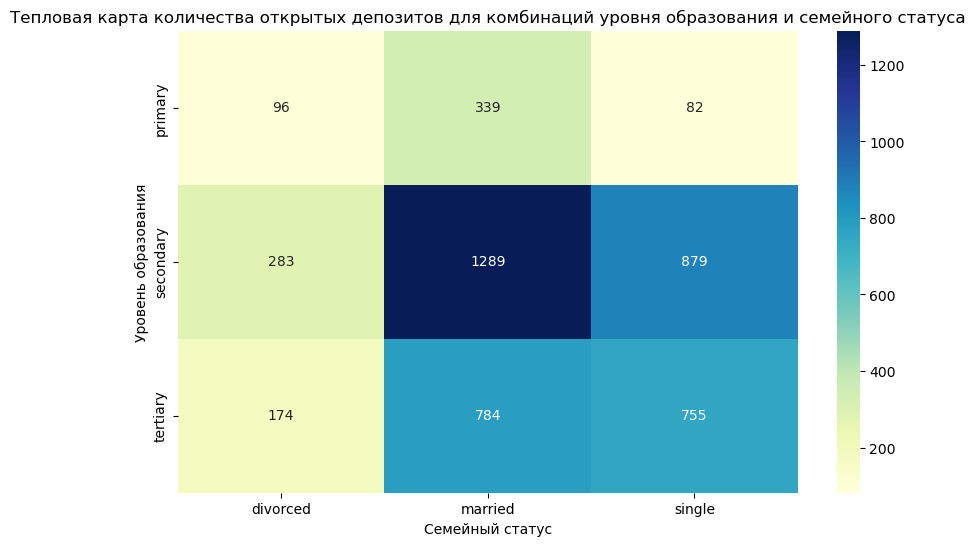

In [649]:
# И для наглядности можно построить тепловую карту, где самое большее пересечение наших категорий нам даст ответ
# Для этого нам потребуется создать сводную таблицу, в которой строки представляют уровень образования, а столбцы - семейный статус
pivot_table_deposit = bank_data[bank_data['deposit'] == 'yes'].pivot_table(index='education', columns='marital', aggfunc='size', fill_value=0)

# Построим тепловую карту
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table_deposit, annot=True, fmt='d', cmap='YlGnBu', cbar=True)
plt.title('Тепловая карта количества открытых депозитов для комбинаций уровня образования и семейного статуса')
plt.xlabel('Семейный статус')
plt.ylabel('Уровень образования')
plt.show()

Видим, что больше всего открывают депозит люди с уровнем образования - secondary и семейным положением - married

## Часть 3: Отбор и преобразование данных

Перед тем как перейти к построению модели, осталось сделать ещё один шаг.

* Следует помнить, что алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. По ходу работы алгоритм считает показатели (например, средние значения), которые можно вычислить только для количественных признаков. Поэтому нам необходимо преобразовать категориальные признаки в более удобный формат.
* Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить качество модели.
* Надо отобрать признаки, которые мы будем использовать для обучения модели.

**3.1**

In [650]:
# Преобразуем уровни образования
# Обработаем его с помощью метода LabelEncoder, используя метод без дополнительных настроек.
# LabelEncoder просто заменит категориальные значения числами

# Создадим экземпляр класса LabelEncoder
label_encoder = LabelEncoder()

# Применим LabelEncoder к education
bank_data['education'] = label_encoder.fit_transform(bank_data['education'])

# Посмотрим на результат
print(bank_data['education'].head())

0    1
1    1
2    1
3    1
4    2
Name: education, dtype: int32


In [651]:
# Найдем сумму получившихся значений для признака education_encoded
bank_data['education'].sum()

11995

**3.2 и 3.3**

Ранее мы создали порядковую переменную для возраста **_age_group_**. Обработаем её по такому же принципу, чтобы её можно было использовать при обучении модели.

In [652]:
# Применим LabelEncoder к education
bank_data['age_group'] = label_encoder.fit_transform(bank_data['age_group'])

# Посмотрим на результат
print(bank_data['age_group'].head())

0    2
1    2
2    1
3    2
4    2
Name: age_group, dtype: int32


In [653]:
display(bank_data)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,59,admin.,married,1,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,2
1,56,admin.,married,1,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,2
2,41,technician,married,1,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,1
3,55,services,married,1,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,2
4,54,admin.,married,2,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,0,no,1.0,yes,no,cellular,20,apr,257,1,-1,0,unknown,no,0
11158,39,services,married,1,no,733.0,no,no,unknown,16,jun,83,4,-1,0,unknown,no,0
11159,32,technician,single,1,no,29.0,no,no,cellular,19,aug,156,2,-1,0,unknown,no,0
11160,43,technician,married,1,no,0.0,no,yes,cellular,8,may,9,2,172,5,failure,no,1


In [654]:
# Преобразуем бинарные переменные (default, housing, loan, deposit) в представление из нулей и единиц. Для этого заменим 'yes' на 1 и 'no' на 0

binary_cols = ['default', 'housing', 'loan', 'deposit']
for col in binary_cols:
    bank_data[col] = bank_data[col].replace({'yes': 1, 'no': 0})


display(bank_data)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,59,admin.,married,1,0,2343.0,1,0,unknown,5,may,1042,1,-1,0,unknown,1,2
1,56,admin.,married,1,0,45.0,0,0,unknown,5,may,1467,1,-1,0,unknown,1,2
2,41,technician,married,1,0,1270.0,1,0,unknown,5,may,1389,1,-1,0,unknown,1,1
3,55,services,married,1,0,2476.0,1,0,unknown,5,may,579,1,-1,0,unknown,1,2
4,54,admin.,married,2,0,184.0,0,0,unknown,5,may,673,2,-1,0,unknown,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,0,0,1.0,1,0,cellular,20,apr,257,1,-1,0,unknown,0,0
11158,39,services,married,1,0,733.0,0,0,unknown,16,jun,83,4,-1,0,unknown,0,0
11159,32,technician,single,1,0,29.0,0,0,cellular,19,aug,156,2,-1,0,unknown,0,0
11160,43,technician,married,1,0,0.0,0,1,cellular,8,may,9,2,172,5,failure,0,1


In [655]:
# Вычисления стандартного отклонения преобразованной целевой переменной deposit
print("Стандартное отклонение целевой переменной deposit:", round(bank_data['deposit'].std(), 3))

Стандартное отклонение целевой переменной deposit: 0.499


In [656]:
# Вычислим среднее арифметическое для каждой из получившихся переменных (default, housing, loan), далее сложим три результата и округлим
print("Среднее арифметическое для default:", bank_data['default'].mean())
print("Среднее арифметическое для housing:", bank_data['housing'].mean())
print("Среднее арифметическое для loan:", bank_data['loan'].mean())

# Просуммируем результаты
sum_means = np.sum([bank_data['default'].mean(), bank_data['housing'].mean(), bank_data['loan'].mean()])
print("Сумма средних арифметических:", round(sum_means, 3))

Среднее арифметическое для default: 0.016427511133102424
Среднее арифметическое для housing: 0.4811479465611084
Среднее арифметическое для loan: 0.13785254824344384
Сумма средних арифметических: 0.635


In [657]:
#print(bank_data.shape[1])
#bank_data.columns.to_list()

**3.4**

In [658]:
# Теперь нам необходимо преобразовать номинальные переменные, которые могут принимать несколько различных значений. 
# Это переменные job, marital, contact, month, poutcome
# Создадим для них дамми-переменные и объединим их с исходным датафреймом
dummy_variables = pd.get_dummies(bank_data[['job', 'marital', 'contact', 'month', 'poutcome']], drop_first=False)
bank_data_encoded = pd.concat([bank_data, dummy_variables], axis=1)
print(bank_data_encoded.shape[1])
#bank_data_encoded.columns.to_list()

# Удалим исходные номинальные переменные из датафрейма bank_data_encoded
bank_data_encoded = bank_data_encoded.drop(['job', 'marital', 'contact', 'month', 'poutcome'], axis=1)
print(bank_data_encoded.shape[1])
bank_data_encoded.columns.to_list()

51
46


['age',
 'education',
 'default',
 'balance',
 'housing',
 'loan',
 'day',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'deposit',
 'age_group',
 'job_admin.',
 'job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'marital_divorced',
 'marital_married',
 'marital_single',
 'contact_cellular',
 'contact_telephone',
 'contact_unknown',
 'month_apr',
 'month_aug',
 'month_dec',
 'month_feb',
 'month_jan',
 'month_jul',
 'month_jun',
 'month_mar',
 'month_may',
 'month_nov',
 'month_oct',
 'month_sep',
 'poutcome_failure',
 'poutcome_other',
 'poutcome_success',
 'poutcome_unknown']

**3.5 и 3.6**

Теперь оценим мультиколлинеарность и взаимосвязь признаков с целевой переменной.

Для этого построим матрицу корреляций. Дополним её тепловой картой, отражающей результат.

В качестве дополнения визуализации построим столбчатую диаграмму для ранжированных коэффициентов корреляции.

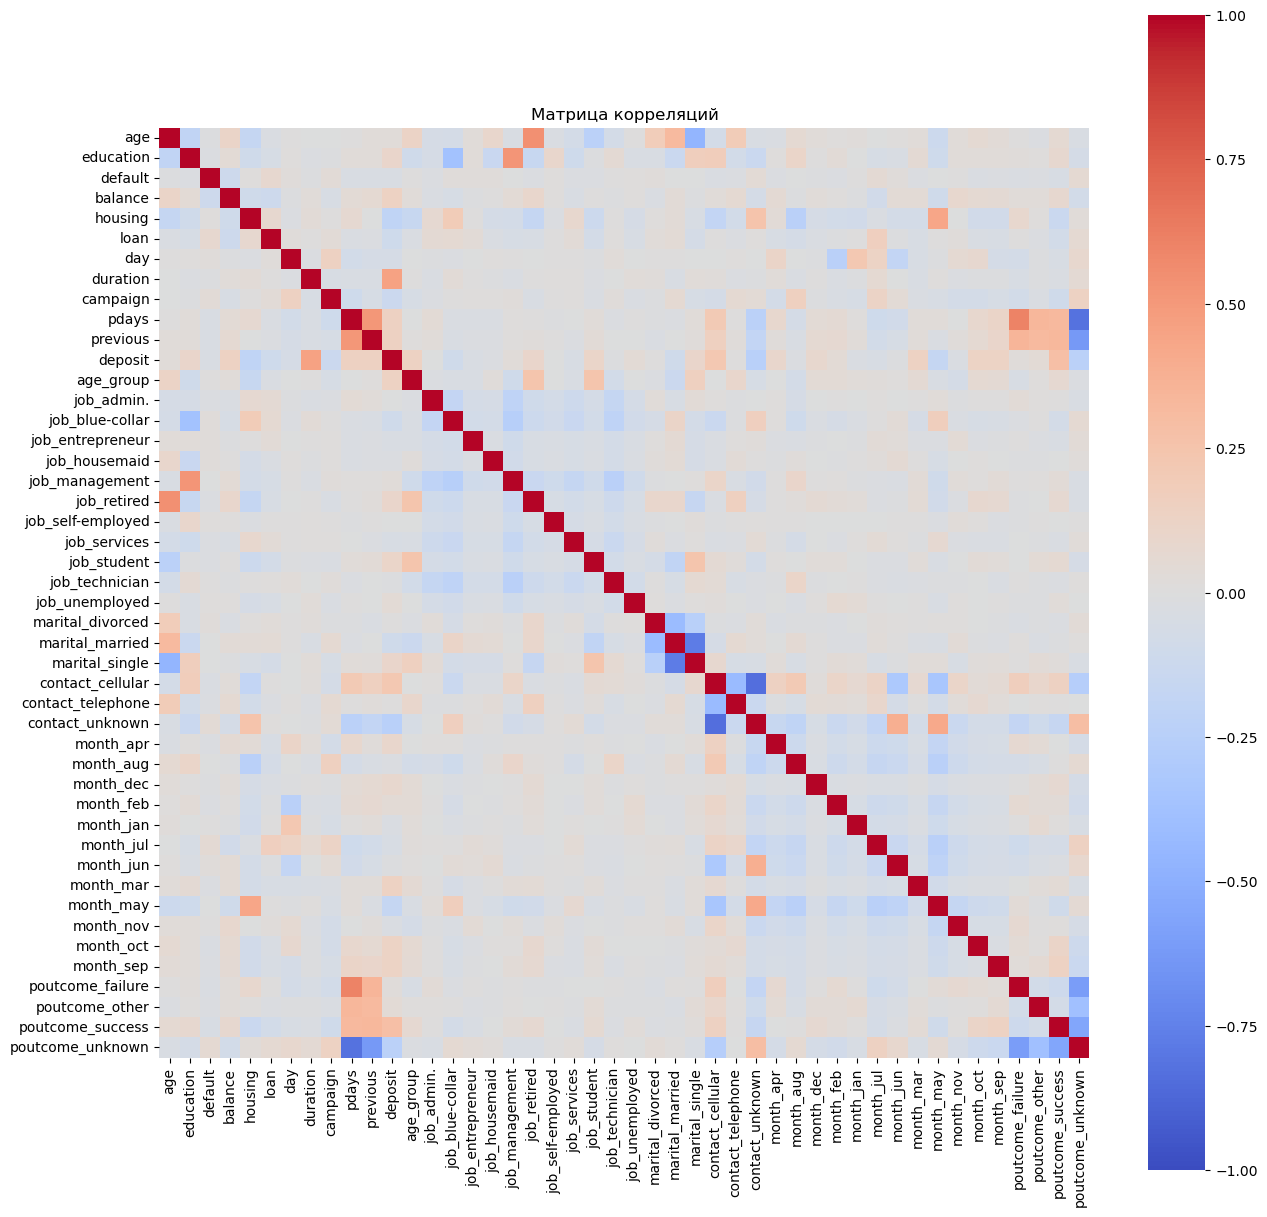

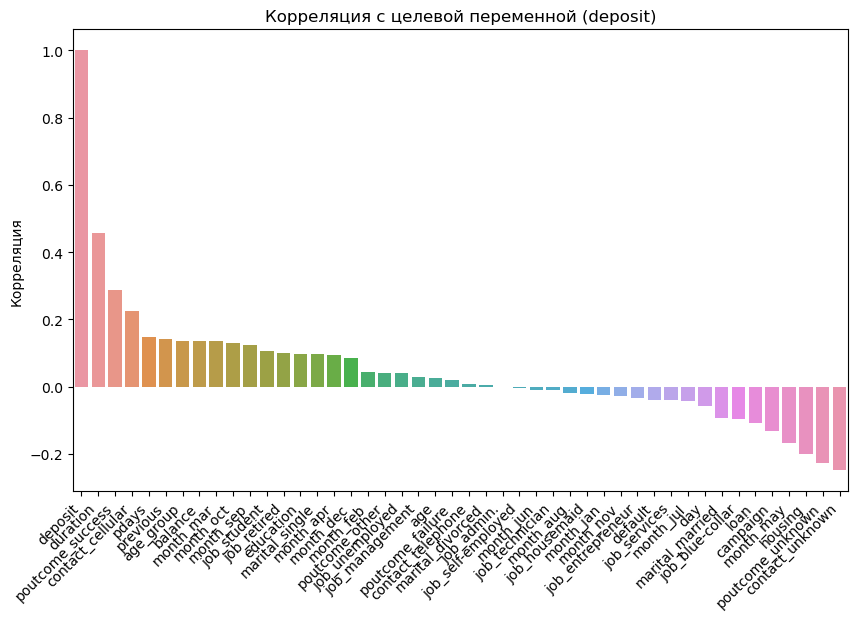

In [659]:
# Построим матрицу корреляций и оценим данные на предмет наличия мультиколлинеарности
correlation_matrix = bank_data_encoded.corr()

# Построим тепловую карту
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, cmap='coolwarm', square=True, vmin=-1, vmax=1, center=0)
plt.title('Матрица корреляций')
plt.show()

# Отобразим столбчатую диаграмму для ранжированных коэффициентов корреляции с целевой переменной deposit
correlation_with_deposit = correlation_matrix['deposit'].sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_with_deposit.index, y=correlation_with_deposit)
plt.title('Корреляция с целевой переменной (deposit)')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Корреляция')
plt.show()

Теперь можно увидеть признаки, в наибольшей степени коррелирующие с целевой переменной, это - duration, poutcome_success, contact_cellular

**3.7 и 3.8**

Теперь нам необходимо определить целевую переменную и предикторы, а также разделить выборку на обучающую и тестовую в соотношении 67/33.
При разбиении зададим параметр random_state = 42, а размер тестовой выборки возьмем за 0.33.

X и y представляют собой две различные части исходного датасета _**bank_data_encoded**_, которые используются в машинном обучении для обучения и тестирования модели

In [660]:
# Матрица признаков(предикторов) без целевой переменной
X = bank_data_encoded.drop(['deposit'], axis=1)
# Наша целевая переменная
y = bank_data_encoded['deposit']

# В параметре stratify передаем y, чтобы сохранить соотношение целевого признака в обучающей и тестовой выборках
# Разделим выборку на обучающую X_train, y_train и тестовую X_test, y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

Теперь у нас есть обучающая и тестовая выборки, а также определены целевая переменная и предикторы. Обучающая выборка содержит 67% данных, а тестовая - 33%. 

In [661]:
# Узнаем размер тестовой выборки
print("Размер тестовой выборки:", X_test.shape[0])

# Узнаем размер обучающей выборки
print("Размер обучающей выборки:", X_train.shape[0])

Размер тестовой выборки: 3335
Размер обучающей выборки: 6770


In [662]:
# Найдем среднее значение целевой переменной на тестовой выборке
print("Среднее значение целевой переменной на тестовой выборке:", round(y_test.mean(), 2))

# Найдем среднее значение целевой переменной на обучающей выборке
print("Среднее значение целевой переменной на обучающей выборке:", round(y_train.mean(), 2))

Среднее значение целевой переменной на тестовой выборке: 0.46
Среднее значение целевой переменной на обучающей выборке: 0.46


**3.9**

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Нужно оставить лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.

С помощью SelectKBest отберем 15 признаков, наилучшим образом подходящих для использования в задаче. Отбор реализуем по обучающей выборке, используя параметр **_score_func = f_classif_**.

In [664]:
# Создадим объект класса SelectKBest с указанием метода оценки score_func = f_classif
selector = SelectKBest(score_func=f_classif, k=15)

# Применим метод fit_transform для обучающей выборки, чтобы получить выборку с отобранными признаками
X_train_selected = selector.fit_transform(X_train, y_train)

# Получим названия отобранных признаков
selected_feature_names = selector.get_feature_names_out()

X_train = X_train[selected_feature_names]
X_test = X_test[selected_feature_names]

# Выведим список отобранных признаков
print(list(selected_feature_names))

['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous', 'age_group', 'contact_cellular', 'contact_unknown', 'month_mar', 'month_may', 'month_oct', 'month_sep', 'poutcome_success', 'poutcome_unknown']


**3.10**

Теперь данные необходимо нормализовать. Мы будем использовать min-max-нормализацию.
Нормализация требуется для предикторов, а не для целевой переменной.
Нормализуем предикторы в обучающей и тестовой выборках.

Нормализация происходит по формуле:
**X_normalized = (X - X_min) / (X_max - X_min)**, 
где **X** - матрица признаков, **X_min** - минимальное значение по каждому признаку, **X_max** - максимальное значение по каждому признаку.

In [665]:
# Создадим объект класса MinMaxScaler
scaler = preprocessing.MinMaxScaler()

# Применим нормализацию на обучающей выборке
# Для этого мы вызываем fit_transform() на обучающей выборке и объект MinMaxScaler "запоминает" 
# минимальные и максимальные значения признаков в обучающей выборке и применяет нормализацию к этой выборке.
X_train_scaled = scaler.fit_transform(X_train)

# Применим ту же нормализацию на тестовой выборке
# Для этого мы вызываем transform() на тестовой выборке и объект MinMaxScaler использует уже "запомненные" 
# минимальные и максимальные значения признаков из обучающей выборки и применяет нормализацию к тестовой выборке 
# с использованием этих значений.
X_test_scaled = scaler.transform(X_test)

In [666]:
# Рассчитаем среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из тестовой выборки
# Выберем первый столбец из тестовой выборки (первый предиктор)
first_predictor = X_test_scaled[:, 0]

# Рассчитаем теперь среднее арифметическое
print("Среднее арифметическое для первого предиктора:", round(np.mean(first_predictor), 2))

Среднее арифметическое для первого предиктора: 0.47


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

**4.1**

Для начала реализуем логистическую регрессию. В качестве алгоритма оптимизации будем использовать 'sag', в качестве значения параметра random_state возьмём число 42 и запустим 1000 итераций.

In [671]:
# Создадим экземпляр класса LogisticRegression с заданными параметрами
logreg_model = linear_model.LogisticRegression(solver='sag', random_state=42, max_iter=1000, class_weight='balanced')

# Обучим нашу модель на обучающей выборке
logreg_model.fit(X_train_scaled, y_train)

# Получим предсказания на обучающей выборке
y_train_pred = logreg_model.predict(X_train_scaled)

# Получим предсказания на тестовой выборке
y_test_pred = logreg_model.predict(X_test_scaled)

Теперь нам нужно рассчитать метрики качества модели на тестовой выборке

В данном случае, так как мы решаем задачу бинарной классификации (предсказание принадлежности к одному из двух классов: согласие или отказ от депозита), можно использовать следующие метрики:

* Accuracy (Точность): Доля правильных предсказаний от общего числа предсказаний.
* Precision (Точность): Доля правильных положительных предсказаний от общего числа положительных предсказаний. Это метрика, которая оценивает, как много из предсказанных согласий действительно являются согласиями.
* Recall (Полнота): Доля правильных положительных предсказаний от общего числа истинных положительных значений. Это метрика, которая оценивает, как много из всех действительных согласий было правильно предсказано.
* F1-score: Среднее гармоническое между точностью и полнотой. Она позволяет учесть и точность и полноту одновременно.

In [672]:
# Оценка accuracy
accuracy = metrics.accuracy_score(y_test, y_test_pred)

# Оценка precision
precision = metrics.precision_score(y_test, y_test_pred)

# Оценка recall
recall = metrics.recall_score(y_test, y_test_pred)

# Оценка F1-score
f1 = metrics.f1_score(y_test, y_test_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

Accuracy: 0.81
Precision: 0.81
Recall: 0.77
F1-score: 0.79


**4.2, 4.3, 4.4**

Теперь обучим ещё один алгоритм — решающие деревья. В качестве параметров для начала возьмём следующие:\
criterion = 'entropy'\
random_state = 42

Но перед тем как приступать к обучению алгоритма нам нужно определить максимальную глубину **_max_depth_**.
Для этого нужно ипользовать перебор возможных значений **_max_depth_**.
И для лучшего определения max_depth возьмем одну метрику качества - **_accuracy_** для которой будем создавать также возможные вариации с max_depth для обучающей и тестовой выборок.

Для этих действий мы будем использовать кривую обучения. Кривая обучения покажет, как изменяется качество модели на обучающей и тестовой выборках при различных значениях максимальной глубины дерева.

Для этого выполним следующие шаги:

* Создадим список различных значений максимальной глубины дерева.
* Для каждого значения глубины дерева:\
a. Создадим экземпляр решающего дерева с указанной глубиной.\
b. Обучим модель на обучающей выборке.\
c. Рассчитаем accuracy на обучающей и тестовой выборках.
* Визуализируем кривую обучения, показывающую изменение accuracy в зависимости от глубины дерева.

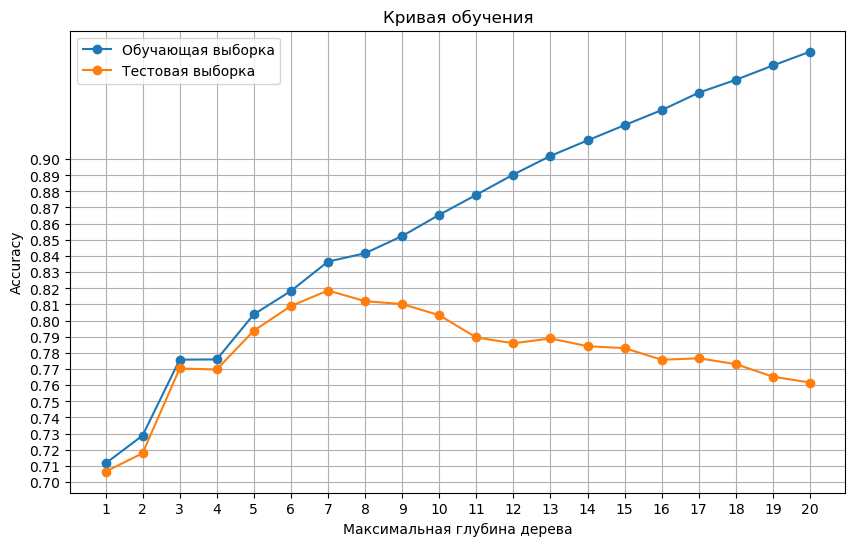

In [717]:
# Список различных значений максимальной глубины дерева, которые будем перебирать
max_depths = range(1, 21)

# Создадим списки для сохранения значений accuracy на обучающей и тестовой выборках
train_accuracy = []
test_accuracy = []

# Перебираем значения максимальной глубины дерева
for depth in max_depths:
    # Создаем экземпляр решающего дерева с указанной глубиной
    tree_model = tree.DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=depth)
    
    # Обучаем модель на обучающей выборке
    tree_model.fit(X_train_scaled, y_train)
    
    # Рассчитываем accuracy на обучающей выборке
    train_accuracy.append(metrics.accuracy_score(y_train, tree_model.predict(X_train_scaled)))
    
    # Рассчитываем accuracy на тестовой выборке
    test_accuracy.append(metrics.accuracy_score(y_test, tree_model.predict(X_test_scaled)))

# Визуализируем кривую обучения
plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_accuracy, label='Обучающая выборка', marker='o')
plt.plot(max_depths, test_accuracy, label='Тестовая выборка', marker='o')
plt.xlabel('Максимальная глубина дерева')
plt.ylabel('Accuracy')
plt.title('Кривая обучения')
plt.legend()
plt.grid(True)
# Добавим значения на оси X и Y
plt.xticks(max_depths)
plt.yticks(list(np.arange(0.7, 0.9, 0.01)))

plt.show()

Оптимальное значение глубины дерева следует выбрать там, где значение accuracy на тестовой выборке находится на плато или начинает немного уменьшаться, а значение accuracy на обучающей выборке стабильно увеличивается.

На первый взгляд на графике можно определить, что искомая max_depth=7 при accuracy=0.82. Но если обратить внимание на разницу в метриках на train и test последовательности, то можно увидеть, что для 7-ки начинается процесс переобучения, а для 6-ки - нет. Значение accuracy при max_depth=7 для train пошло дальше чем на test. Поэтому тут наблюдается явно картина переобучения, а нам нужно ловировать до переобучения. Следовательно определяем для нас max_depth=6.

Теперь можно приступать к обучению нашего алгоритма с максимальной глубиной max_depth = 6.

In [705]:
# Обучим решающие деревья, настроим максимальную глубину max_depth = 6
# Создадим экземпляр класса DecisionTreeClassifier с заданными параметрами
tree_model = tree.DecisionTreeClassifier(criterion = 'entropy', random_state = 42, max_depth = 6)

# Обучим нашу модель на обучающей выборке
tree_model.fit(X_train_scaled, y_train)

# Получим предсказания на обучающей выборке
y_train_pred = tree_model.predict(X_train_scaled)

# Получим предсказания на тестовой выборке
y_test_pred = tree_model.predict(X_test_scaled)

Теперь нам нужно рассчитать метрики качества модели на тестовой выборке

In [706]:
# Оценка accuracy
accuracy = metrics.accuracy_score(y_test, y_test_pred)

# Оценка precision
precision = metrics.precision_score(y_test, y_test_pred)

# Оценка recall
recall = metrics.recall_score(y_test, y_test_pred)

# Оценка F1-score
f1 = metrics.f1_score(y_test, y_test_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

Accuracy: 0.81
Precision: 0.77
Recall: 0.84
F1-score: 0.80


После реализации данного алгоритма и оценки качества модели мы наблюдаем переобучение.

**4.5**

Теперь переберем различные максимальные глубины деревьев для нахождения глубину дерева, для которой будет максимальное значение метрики **_accuracy_**, но при этом ещё не будет наблюдаться переобучение (т. е. не будет расти качество на обучающей выборке при неизменном качестве на тестовой). Мы это уже произвели ранее благодаря кривой переобучения.

Но теперь мы используем GridSearchCV для нахождения оптимальных гиперпараметров, включая максимальную глубину дерева. GridSearchCV выполнит кросс-валидацию для каждой комбинации максимальной глубины дерева из заданной сетки значений и выберет ту, которая дает наилучшее качество на кросс-валидации. Затем он вернет лучшую модель с оптимальными гиперпараметрами.

In [714]:
# Зададим сетку значений для параметра max_depth, которые будем перебирать
param_grid = {'max_depth': range(1, 21)}

# Создадим экземпляр GridSearchCV для метрики accuracy
grid_search = GridSearchCV(tree_model, param_grid, cv=3, scoring='accuracy')

# Обучим GridSearchCV на обучающей выборке
grid_search.fit(X_train_scaled, y_train)

# Выведим наилучшую комбинацию гиперпараметров и соответствующее значение accuracy
print("Наилучшие гиперпараметры:", grid_search.best_params_)
print("Accuracy наилучшей модели на кросс-валидации:", round(grid_search.best_score_, 2))

# Получим лучшую модель
best_model = grid_search.best_estimator_

# Рассчитаем accuracy на тестовой выборке с использованием лучшей модели
test_accuracy = metrics.accuracy_score(y_test, best_model.predict(X_test_scaled))
print("Accuracy на тестовой выборке с использованием лучшей модели:", round(test_accuracy, 2))

Наилучшие гиперпараметры: {'max_depth': 6}
Accuracy наилучшей модели на кросс-валидации: 0.81
Accuracy на тестовой выборке с использованием лучшей модели: 0.81


Попробуем перебрать сразу большое количество комбинаций различных параметров и выбрать тот вариант, при котором модель будет давать наиболее точный прогноз.

Реализуем оптимизацию гиперпараметров с помощью GridSearchCV, перебрав следующие параметры:\
'min_samples_split': [2, 5, 7, 10]\
'max_depth':[3,5,7]

А далее оценим метрику **_F1-score_** на тестовой выборке для наилучшей комбинации перебираемых параметров.

In [716]:
# Зададим значения параметров, которые хотим перебрать
param_grid = {
    'min_samples_split': [2, 5, 7, 10],
    'max_depth': [3, 5, 7]
}

# Создадим экземпляр GridSearchCV с моделью решающего дерева и параметрами для перебора
grid_search = GridSearchCV(tree_model, param_grid, cv=3, scoring='f1', return_train_score=True)

# Обучим GridSearchCV на обучающей выборке
grid_search.fit(X_train_scaled, y_train)

# Получим лучшие параметры
best_params = grid_search.best_params_

# Получим лучшую модель
best_model = grid_search.best_estimator_

# Выведим наилучшую комбинацию гиперпараметров и соответствующее значение accuracy
print("Наилучшие гиперпараметры:", grid_search.best_params_)
print("F1-score наилучшей модели на кросс-валидации:", round(grid_search.best_score_, 2))

# Получим лучшую модель
best_model = grid_search.best_estimator_

# Рассчитаем F1-score на тестовой выборке с использованием лучшей модели
test_accuracy = metrics.f1_score(y_test, best_model.predict(X_test_scaled))
print("F1-score на тестовой выборке с использованием лучшей модели:", round(test_accuracy, 2))

Наилучшие гиперпараметры: {'max_depth': 7, 'min_samples_split': 5}
F1-score наилучшей модели на кросс-валидации: 0.8
F1-score на тестовой выборке с использованием лучшей модели: 0.81


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

Мы обучили решающие деревья, и теперь пришла пора объединить их в случайный лес. Случайный лес - это ансамбль решающих деревьев, где каждое дерево обучается на подвыборке данных с заменой, а также используется только подмножество признаков для разделения в каждом узле дерева. Затем результаты всех деревьев суммируются или усредняются для получения окончательного предсказания.

Обучим теперь случайный лес со следующими параметрами:

* Количество деревьев - n_estimators = 100\
* Критерий, по которому будет производиться разделение данных на подмножества в каждом узле - criterion = 'gini'\
* минимальное количество объектов для разделения узла - min_samples_leaf = 5\
* Максимальная глубина деревьев - max_depth = 10\
* random_state = 42 для воспроизводимости результатов.

**5.1**

In [718]:
# Создадим экземпляр класса RandomForestClassifier с заданными параметрами
rf_model = ensemble.RandomForestClassifier(n_estimators = 100, 
                                           criterion = 'gini', 
                                           min_samples_leaf = 5, 
                                           max_depth = 10, 
                                           random_state = 42)

# Обучим модель на обучающей выборке
rf_model.fit(X_train_scaled, y_train)

# Получим предсказания на обучающей выборке
y_train_pred = rf_model.predict(X_train_scaled)

# Получим предсказания на тестовой выборке
y_test_pred = rf_model.predict(X_test_scaled)

Теперь нам нужно рассчитать метрики качества модели на тестовой выборке.

In [721]:
# Оценка accuracy
accuracy = metrics.accuracy_score(y_test, y_test_pred)

# Оценка precision
precision = metrics.precision_score(y_test, y_test_pred)

# Оценка recall
recall = metrics.recall_score(y_test, y_test_pred)

# Оценка F1-score
f1 = metrics.f1_score(y_test, y_test_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

Accuracy: 0.83
Precision: 0.80
Recall: 0.83
F1-score: 0.82


**5.2 и 5.3**

Теперь попробуем использовать градиентный бустинг для решения задачи классификации, задав для него следующие параметры:

learning_rate = 0.05\
n_estimators = 300\
min_samples_leaf = 5\
max_depth = 5\
random_state = 42.

In [724]:
# Используем для классификации градиентный бустинг и сравним качество со случайным лесом
# Создадим экземпляр класса GradientBoostingClassifier с заданными параметрами
gb_model = ensemble.GradientBoostingClassifier(learning_rate = 0.05,
                                               n_estimators = 300,
                                               min_samples_leaf = 5,
                                               max_depth = 5,
                                               random_state = 42)

# Обучим модель на обучающей выборке
gb_model.fit(X_train_scaled, y_train)

# Получим предсказания на обучающей выборке
y_train_pred = gb_model.predict(X_train_scaled)

# Получим предсказания на тестовой выборке
y_test_pred = gb_model.predict(X_test_scaled)

Теперь нам нужно снова рассчитать метрики качества модели на тестовой выборке.

In [725]:
# Оценка accuracy
accuracy = metrics.accuracy_score(y_test, y_test_pred)

# Оценка precision
precision = metrics.precision_score(y_test, y_test_pred)

# Оценка recall
recall = metrics.recall_score(y_test, y_test_pred)

# Оценка F1-score
f1 = metrics.f1_score(y_test, y_test_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

Accuracy: 0.83
Precision: 0.80
Recall: 0.83
F1-score: 0.82


Можно сделать вывод, что и случайный лес и градиентный бустинг показали одинаковые результаты качества на тестовой выборке.

**5.4**

Настало время построить ансамбль из моделей разного типа.

Нам необходимо использовать стекинг, объединив те алгоритмы, которые мы уже использовали ранее: решающие деревья, логистическую регрессию и градиентный бустинг. В качестве метамодели используем модель логистической регрессии.

Параметры алгоритмов оставим те же, что были в предыдущих заданиях.

In [728]:
# Объединим уже известные вам алгоритмы с помощью стекинга
# Для этого создадим список с базовыми моделями
base_models = [
    ('DecisionTree', tree.DecisionTreeClassifier(criterion='entropy', 
                                                 random_state=42, 
                                                 max_depth = 6,
                                                 min_samples_leaf=5)),
    ('LogisticRegression', linear_model.LogisticRegression(solver='sag', 
                                                           random_state=42)),
    ('GradientBoosting', ensemble.GradientBoostingClassifier(learning_rate=0.05, 
                                                             n_estimators=300, 
                                                             min_samples_leaf=5, 
                                                             max_depth=5, 
                                                             random_state=42))
]

# Создадим метамодель (логистическую регрессию)
meta_model = linear_model.LogisticRegression(random_state=42)

# Создадим стекинг классификатор
stacking_model = ensemble.StackingClassifier(estimators=base_models, final_estimator=meta_model)

# Обучим стекинг модель на обучающей выборке
stacking_model.fit(X_train_scaled, y_train)

# Получим предсказания на обучающей выборке
y_train_pred = stacking_model.predict(X_train_scaled)

# Получим предсказания на тестовой выборке
y_test_pred = stacking_model.predict(X_test_scaled)


Теперь снова рассчитаем метрики качества модели на тестовой выборке.

In [729]:
# Оценка accuracy
accuracy = metrics.accuracy_score(y_test, y_test_pred)

# Оценка precision
precision = metrics.precision_score(y_test, y_test_pred)

# Оценка recall
recall = metrics.recall_score(y_test, y_test_pred)

# Оценка F1-score
f1 = metrics.f1_score(y_test, y_test_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

Accuracy: 0.82
Precision: 0.81
Recall: 0.81
F1-score: 0.81


Метрики оценки качества изменились по сравнению с предыдущими метриками моделей. Это связано с тем, что стекинг комбинирует предсказания разных моделей, что может привести к более точным и устойчивым результатам. Видим, что в целом метрики оценки качества (accuracy, recall,  F1-score) на тестовой выборке после применения стекинга ухудшились по сравнению с базовыми моделями. Только метрика precision улучшилась.

**5.5**

In [731]:
# Оценим, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
# Для оценки важности признаков в модели градиентного бустинга можно воспользоваться атрибутом feature_importances_, 
# который содержит значения оценок важности каждого признака. 
# Более высокие значения означают, что признак вносит больший вклад в принятие решения моделью.

# Получим оценки важности для каждого признака
feature_importance = gb_model.feature_importances_

# Создадим датафрейм с оценками важности признаков
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

# Отсортируем признаки по их важности
sorted_feature_importance = feature_importance_df.sort_values(by='Importance', ascending=False)

# Посмотрим на результат
print(sorted_feature_importance)

             Feature  Importance
2           duration    0.501987
13  poutcome_success    0.116264
8    contact_unknown    0.073762
0            balance    0.059764
4              pdays    0.055647
1            housing    0.046583
6          age_group    0.042102
9          month_mar    0.026144
11         month_oct    0.018824
3           campaign    0.017101
10         month_may    0.014508
12         month_sep    0.013428
5           previous    0.008901
7   contact_cellular    0.004600
14  poutcome_unknown    0.000386


Наибольшую важность в модели градиентного бустинга вкладывают признаки: duration, poutcome_success, contact_unknown 

**5.6, 5.7, 5.8**

Попробуем теперь снова произвести оптимизацию гиперпараметров, но уже использовав один из более продвинутых вариантов — фреймворк Optuna. Для перебора возьмем случайный лес и следующие параметры:

n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)\
max_depth = trial.suggest_int('max_depth', 10, 30, 1)\
min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

In [736]:
# Функция для оптимизации гиперпараметров
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    # Создадим модель случайного леса с заданными параметрами
    rf_model = ensemble.RandomForestClassifier(n_estimators=n_estimators, 
                                               max_depth=max_depth, 
                                               min_samples_leaf=min_samples_leaf, 
                                               random_state=42)

    # Выполним перекрестную проверку для оценки качества модели
    scores = model_selection.cross_val_score(rf_model, X_train_scaled, y_train, cv=3, scoring='accuracy')

    # Возвратим среднее значение точности (accuracy) из перекрестной проверки
    return scores.mean()


Теперь можно реализовать оптимизацию гиперпараметров с помощью Optuna.

In [743]:
# Создадим объект Optuna Study для оптимизации
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Выведим наилучшие значения гиперпараметров
best_params = study.best_params
print("Наилучшие параметры:", best_params)

# Создадим модель случайного леса с найденными оптимальными параметрами
best_rf_model = ensemble.RandomForestClassifier(n_estimators=best_params['n_estimators'], 
                                               max_depth=best_params['max_depth'], 
                                               min_samples_leaf=best_params['min_samples_leaf'], 
                                               random_state=42)

# Обучим модель на обучающей выборке
best_rf_model.fit(X_train_scaled, y_train)

# Получим предсказания на обучающей выборке
y_train_pred = best_rf_model.predict(X_train_scaled)

# Получим предсказания на тестовой выборке
y_test_pred = best_rf_model.predict(X_test_scaled)

[I 2023-07-29 10:22:15,709] A new study created in memory with name: no-name-d9f909b2-8534-491a-bb47-702cb9bb6993
[I 2023-07-29 10:22:17,476] Trial 0 finished with value: 0.8329394314090862 and parameters: {'n_estimators': 184, 'max_depth': 13, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8329394314090862.
[I 2023-07-29 10:22:18,500] Trial 1 finished with value: 0.8305764126526247 and parameters: {'n_estimators': 101, 'max_depth': 24, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8329394314090862.
[I 2023-07-29 10:22:19,767] Trial 2 finished with value: 0.8329399551277822 and parameters: {'n_estimators': 140, 'max_depth': 28, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.8329399551277822.
[I 2023-07-29 10:22:21,192] Trial 3 finished with value: 0.8342688258541067 and parameters: {'n_estimators': 170, 'max_depth': 18, 'min_samples_leaf': 5}. Best is trial 3 with value: 0.8342688258541067.
[I 2023-07-29 10:22:22,232] Trial 4 finished with value: 0.832939562338760

[I 2023-07-29 10:23:18,113] Trial 40 finished with value: 0.8351551542822907 and parameters: {'n_estimators': 178, 'max_depth': 15, 'min_samples_leaf': 3}. Best is trial 40 with value: 0.8351551542822907.
[I 2023-07-29 10:23:20,168] Trial 41 finished with value: 0.8327923319203402 and parameters: {'n_estimators': 188, 'max_depth': 16, 'min_samples_leaf': 3}. Best is trial 40 with value: 0.8351551542822907.
[I 2023-07-29 10:23:22,135] Trial 42 finished with value: 0.8338264144856402 and parameters: {'n_estimators': 176, 'max_depth': 13, 'min_samples_leaf': 2}. Best is trial 40 with value: 0.8351551542822907.
[I 2023-07-29 10:23:23,931] Trial 43 finished with value: 0.83308744740555 and parameters: {'n_estimators': 180, 'max_depth': 14, 'min_samples_leaf': 3}. Best is trial 40 with value: 0.8351551542822907.
[I 2023-07-29 10:23:25,618] Trial 44 finished with value: 0.8344165145263855 and parameters: {'n_estimators': 168, 'max_depth': 15, 'min_samples_leaf': 4}. Best is trial 40 with valu

[I 2023-07-29 10:24:31,747] Trial 80 finished with value: 0.8327917427368073 and parameters: {'n_estimators': 192, 'max_depth': 17, 'min_samples_leaf': 4}. Best is trial 40 with value: 0.8351551542822907.
[I 2023-07-29 10:24:33,700] Trial 81 finished with value: 0.8336783330243392 and parameters: {'n_estimators': 197, 'max_depth': 13, 'min_samples_leaf': 3}. Best is trial 40 with value: 0.8351551542822907.
[I 2023-07-29 10:24:35,740] Trial 82 finished with value: 0.8342690877134546 and parameters: {'n_estimators': 198, 'max_depth': 11, 'min_samples_leaf': 2}. Best is trial 40 with value: 0.8351551542822907.
[I 2023-07-29 10:24:37,719] Trial 83 finished with value: 0.8320536921644351 and parameters: {'n_estimators': 188, 'max_depth': 19, 'min_samples_leaf': 3}. Best is trial 40 with value: 0.8351551542822907.
[I 2023-07-29 10:24:39,372] Trial 84 finished with value: 0.8305766090471357 and parameters: {'n_estimators': 161, 'max_depth': 16, 'min_samples_leaf': 2}. Best is trial 40 with va

[I 2023-07-29 10:25:46,958] Trial 120 finished with value: 0.8333825628907596 and parameters: {'n_estimators': 192, 'max_depth': 10, 'min_samples_leaf': 3}. Best is trial 40 with value: 0.8351551542822907.
[I 2023-07-29 10:25:49,131] Trial 121 finished with value: 0.8338260216966181 and parameters: {'n_estimators': 194, 'max_depth': 11, 'min_samples_leaf': 2}. Best is trial 40 with value: 0.8351551542822907.
[I 2023-07-29 10:25:51,224] Trial 122 finished with value: 0.8348599078674069 and parameters: {'n_estimators': 198, 'max_depth': 10, 'min_samples_leaf': 2}. Best is trial 40 with value: 0.8351551542822907.
[I 2023-07-29 10:25:53,215] Trial 123 finished with value: 0.8344167109208965 and parameters: {'n_estimators': 197, 'max_depth': 10, 'min_samples_leaf': 2}. Best is trial 40 with value: 0.8351551542822907.
[I 2023-07-29 10:25:55,400] Trial 124 finished with value: 0.8329397587332711 and parameters: {'n_estimators': 200, 'max_depth': 11, 'min_samples_leaf': 2}. Best is trial 40 wi

[I 2023-07-29 10:27:05,816] Trial 160 finished with value: 0.8342690877134546 and parameters: {'n_estimators': 198, 'max_depth': 11, 'min_samples_leaf': 2}. Best is trial 40 with value: 0.8351551542822907.
[I 2023-07-29 10:27:07,673] Trial 161 finished with value: 0.8347121537302912 and parameters: {'n_estimators': 200, 'max_depth': 10, 'min_samples_leaf': 2}. Best is trial 40 with value: 0.8351551542822907.
[I 2023-07-29 10:27:09,531] Trial 162 finished with value: 0.8347121537302912 and parameters: {'n_estimators': 200, 'max_depth': 10, 'min_samples_leaf': 2}. Best is trial 40 with value: 0.8351551542822907.
[I 2023-07-29 10:27:11,359] Trial 163 finished with value: 0.8344167109208965 and parameters: {'n_estimators': 197, 'max_depth': 10, 'min_samples_leaf': 2}. Best is trial 40 with value: 0.8351551542822907.
[I 2023-07-29 10:27:13,190] Trial 164 finished with value: 0.8348599078674069 and parameters: {'n_estimators': 198, 'max_depth': 10, 'min_samples_leaf': 2}. Best is trial 40 wi

Наилучшие параметры: {'n_estimators': 178, 'max_depth': 15, 'min_samples_leaf': 3}


Произведем оценку метрик качества

In [744]:
# Оценка accuracy
accuracy = metrics.accuracy_score(y_test, y_test_pred)

# Оценка precision
precision = metrics.precision_score(y_test, y_test_pred)

# Оценка recall
recall = metrics.recall_score(y_test, y_test_pred)

# Оценка F1-score
f1 = metrics.f1_score(y_test, y_test_pred)

print(f"Случайный лес:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

Случайный лес:
Accuracy: 0.83
Precision: 0.80
Recall: 0.84
F1-score: 0.82


С помощью Optuna нам удалось улучшить результат качества по сравнению с предыдущими моделями.